In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00
Mounted at /content/gdrive


In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
Path.BASE_PATH = path

In [6]:
# ls 메서드를 통해 해당 디렉토리의 내용을 확인
# MNIST는 학습과 검증(또는 테스트용) 데이터셋을 별도의 폴더로 분리해서 보관하는 일반적인 머신러닝 데이터셋의 구조를 따름
print(path.ls())

[Path('labels.csv'), Path('valid'), Path('train')]


In [7]:

# 학습 데이터셋의 폴더 내용 확인
print((path/'train').ls()) # 출력물에 나온 '3'과 '7'을 데이터셋의 레이블이라고 표현함

[Path('train/7'), Path('train/3')]


In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [9]:
# 수 많은 이미지 파일 중 하나 확인
im3_path = threes[1]
im3 = Image.open(im3_path) # 파이썬 영상 처리 라이브러리가 제공하는 Image 클래스 활용
im3

In [10]:
# 1. 컴퓨터가 어떻게 이미지를 바라보는지 알아보기
# 컴퓨터는 모든 것을 숫자로 표현함. 이미지를 구성하는 숫자를 확인하려면, 이미지를 '넘파이 배열' 또는 '파이토치 텐서'로 변환해야함
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
# '팬던스' 데이터프레임을 숫자의 값에 따라 색상을 그라데이션 형태로 입히는 방법을 보여줌
# 그러면 픽셀값에 따라 이미지가 구성된 방식을 확인할 수 있음
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [13]:
# 첫 번째 시도 : 픽셀 유사성
# - 숫자 3과 7 각각에 대한 모든 이미지의 평균 픽셀값을 구함
# - 두 숫자에 대해 얻은 평균 픽셀값을 각각 '이상적인' 3과 7로 정의함
# - 그리고 새로운 이미지가 이상적인 두 이미지 중 어느 쪽에 가까운지 계산하여 분류함

# 리스트 컴프리헨션으로 만든 리스트에 기대한 개수만큼 아이템이 들어있는지를 확인하는 코드
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

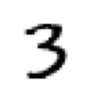

In [14]:
show_image(three_tensors[1]) # tensor 형식으로 담긴 이미지를 출력하려면 fastai가 제공하는 show_image 함수 활용

In [15]:
# 픽셀값을 부동소수로 표현할 때는 그 값을 0과 1 사이로 맞춤.
# 다음과 같이 255로 나누어 픽셀값이 0~1 범위가 되도록 변환함
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape # 출력 내용을 통해 이미지가 6,131장 있으며, 각각 28x28 픽셀로 구성되었음을 알 수 있음

torch.Size([6131, 28, 28])

In [16]:
# 텐서의 shape 속성 길이는 랭크라고 표현함
len(stacked_threes.shape)

3

In [17]:
# ndim 속성으로 텐서의 랭크를 즉시 확인
stacked_threes.ndim

3

<Axes: >

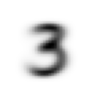

In [18]:
# 각 픽셀 위치에 대한 모든 이미지의 평균을 구하고, 평균 픽셀값으로 구성된 이미지 한 장을 만듦
# 다음은 계산 방법과 출력된 이상적인 숫자 3의 모습
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

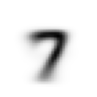

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<Axes: >

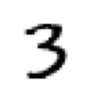

In [20]:
# 임의로 선택한 숫자 3 샘플
a_3 = stacked_threes[1]
show_image(a_3)

In [21]:
# 이상적인 숫자 3과의 거리를 어떻게 결정할까?
# - 1. L1 노름, 평균절대차 : 차이의 절댓값에 대한 평균을 구하는(음수를 양수화) 방법
# - 2. L2 노름, 평규제곱근오차 : 차이의 제곱(모든 수를 양수화함)에 대한 평균의 제곱근(제곱을 다시 원상태로 돌림)을 구하는 방법

# L1 노름 적용
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
# L1 노름 적용
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [23]:
# 위 코드에서 알수 있는 것은 선택한 숫자 3 이미지는 '이상적인' 숫자 7보다 이상적인 숫자 3 과의 거리가 더 짧음
# 즉, 간단히 만든 기준선 모델이 예측을 올바르게 수행했다고 확인할 수 있음

In [24]:
# 파이토치는 이 두 방법에 대한 '손실 함수'를 제공함. 각 손실 함수는 torch.nn.functional 에서 찾아볼 수 있음
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [25]:
# 파이토치 텐서 학습
data = [[1, 2, 3], [4, 5, 6]]
arr = array(data)
tns = tensor(data)


In [26]:
arr # 넘파이

array([[1, 2, 3],
       [4, 5, 6]])

In [27]:
tns # 파이토치

tensor([[1, 2, 3],
        [4, 5, 6]])

In [28]:
tns[1]

tensor([4, 5, 6])

In [29]:
tns[:, 1]

tensor([2, 5])

In [30]:
tns[:, 2]

tensor([3, 6])

In [31]:
tns[1, 1:3]

tensor([5, 6])

In [32]:
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [33]:
tns.type() # 텐서에는 자료형이 있음

'torch.LongTensor'

In [34]:
tns * 1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

In [35]:
# 평가지표란? 데이터셋에 표기된 올바른 레이블과 모델이 도출한 예측을 비교해서 모델이 얼마나 좋은지를 평가하는 단일 숫자
# - 평균제곱오차, 평균저래오차, 전체평균
# 하지만, 위의 세 지표 모두 사람이 직관적으로 이해하기 쉽지 않으므로 '정확도'를 분류 모델 평가지표로 사용함(평가지표를 계산하려는 대상은 '검증용 데이터셋')

In [36]:
# 검증용 데이터가 있는 디렉토리에서 3과 7에 대한 텐서를 만듦
# 이상적인 이미지와의 거리를 측정하는 첫 번째 모델의 품질 평가지표를 계산하는 데 사용할 텐서임
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape # 이미지는 1,010 장 크기는 28*28

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [37]:
# 평균절대오차를 계산하는 함수 정의
def mnist_distance(a, b) :
  return (a-b).abs().mean((-1, -2))

mnist_distance(a_3, mean3)

tensor(0.1114)

In [38]:
# 숫자 3의 검증용 데이터셋을 나태내는 텐서 valid_3_tens를 mnist_distance 함수에 넣어 주면다음과 같은 흥미로운 일이 발생함
# 이 과정에서 '브로드캐스팅'이 발생함
# 더 낮은 랭크의 텐서를 더 높은 랭크의 텐서와 같은 크기로 자동 확장함
# 텐서를 사용한 코드를 훨씬 쉽고 간결하게 난들어주는 매우 중요한 기능임
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1334, 0.1305, 0.1308,  ..., 0.1283, 0.1192, 0.1086]),
 torch.Size([1010]))

In [39]:
tensor([1, 2, 3]) + tensor(1)

tensor([2, 3, 4])

In [40]:
# 성능, 표현성 측면에서 모두 뛰어난 브로드캐스팅을 구현할 때 중요한 고려사항이 두 가지가 있음
# - 1. 파이토치는 mean3을 1,010번 복사하지 않음. 그 모양의 텐서인 척하지만, 실제로 메모리를 추가 할당하지는 않음
# - 2. 실제 모든 계산은 C로 수행됨. 순수 파이썬보다 수만 배 빠르며, GPU 사용 시 수백만 배 빠르게 계산을 수행함
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

In [41]:
# mnist_distance 함수를 '만약 특정 숫자 이미지와 이상적인 숫자 3과의 거리가 이상적인 숫자 7과의 거리보다 짧다면,
# 그 숫자 이미지를 3이라고 판단하는 '로직에 활용하면 이미지가 숫자 3인지를 알아낼 수 있음'
# 이 함수는 모든 파이토치의 함수와 연산자처럼 자동으로 브로드캐스팅을 수행하고 요소별로 적용될 수 있음
def is_3(x) :
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [42]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [43]:
# is_3 함수를 이용하여 검증용 데이터셋의 모든 숫자 3과 7에 대한 평균을 계산해서 정확도를 계산할 수 있음
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2 # 숫자 3과 7 모두에서 90%가 넘는 정확도를 얻었음

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [44]:
# 이미지 픽셀(x)과 각 픽셀에 대한 가중치(w)를 입력받는 함수로 표현할 수 있음
# - x는 2차원으로 표현된 픽셀의 각 행을 이어붙인 1차원의 긴 배열이라고 가정
# - w는 가중치 벡터
def pr_three(x, w) :
  return (x*w).sum()

# 📌 함수를 머신러닝 분류 모델로 만드는 데 필요한 단계


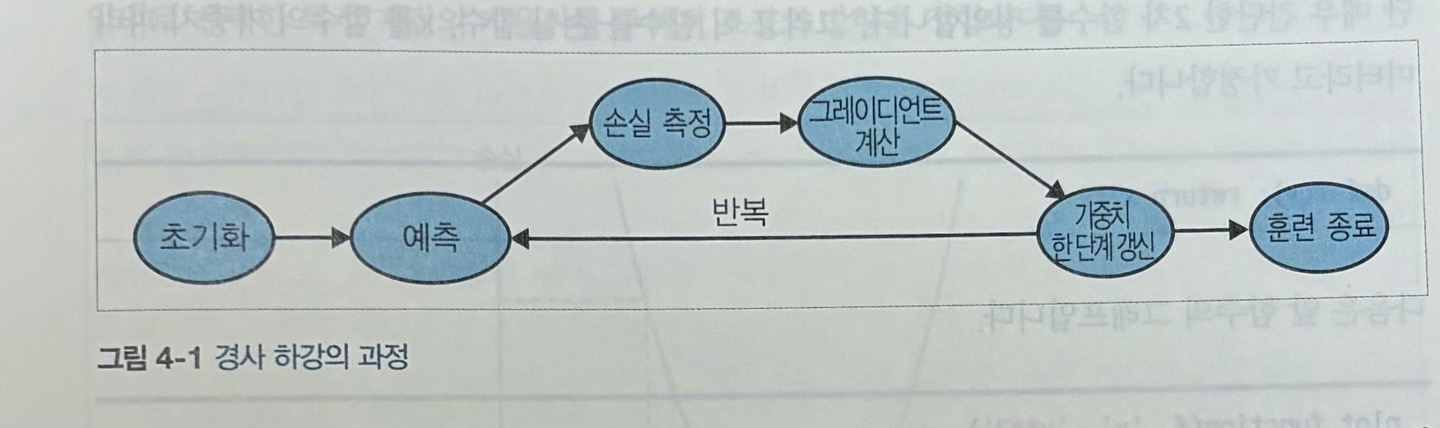

### - 1. 가중치를 초기화함
### - 2. 현재 가중치로 이미지가 3 또는 7인지를 예측함
### - 3. 예측한 결과로 모델이 얼마나 좋은지 계산함(손실 측정)
### - 4. 가중치 갱신 정도가 손실에 미치는 영향을 측정하는 그레이디어느를 계산함
### - 5. 4번 단계에서 계산한 그레이디언트로 가중치의 값을 한 단계 조정함
### - 6. 2번 단계로 돌아가서 과정을 반복함
### - 7. 학습 과정을 멈춰도 좋다는 판단이 설 때까지 계속해서 반복함(모델 성능이 충분하다고 판단하거나, 시간 상 제약으로 멈춰야 할지도 모름)



### 초기화

> - 파라미터의 값을 무작위로 초기화함
> - 가중치를 개선하는 일련의 과정을 거치면 무작위로 초기화된 가중치가 꽤 잘 작동하는 방향으로 갱신됨

### 손실

> - 현재 할당된 가중치의 유효성 검증
> - 모델의 성능이 좋을 때 낮은 값을 반환하는 함수가 필요함(일반적으로 적은 손실은 좋고 큰 손실은 나쁘다고 취급함)

### 가중치 단계 갱신

> - 가중치를 약간 크게 또는 작게 조정해야 하는지를 알아내는 간단한 방법은 시도 해보는 것
> - 가중치를 약간씩 조정하고 손실의 변화를 관찰하면 됨


### 훈련 종료

> - 모델을 학습할 애포크 횟수를 정하고 적용함

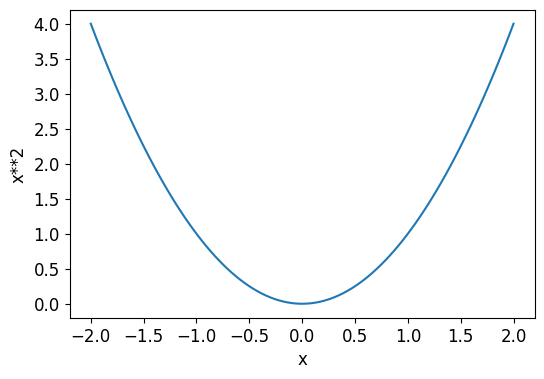

In [45]:
# 위의 과정을 간단한 예로 살펴보기
def f(x):
  return x ** 2


plot_function(f, 'x', 'x**2')

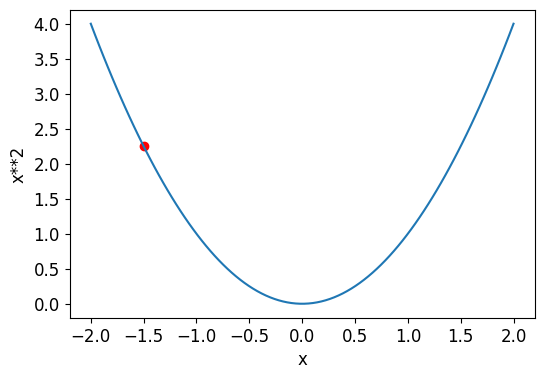

In [46]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

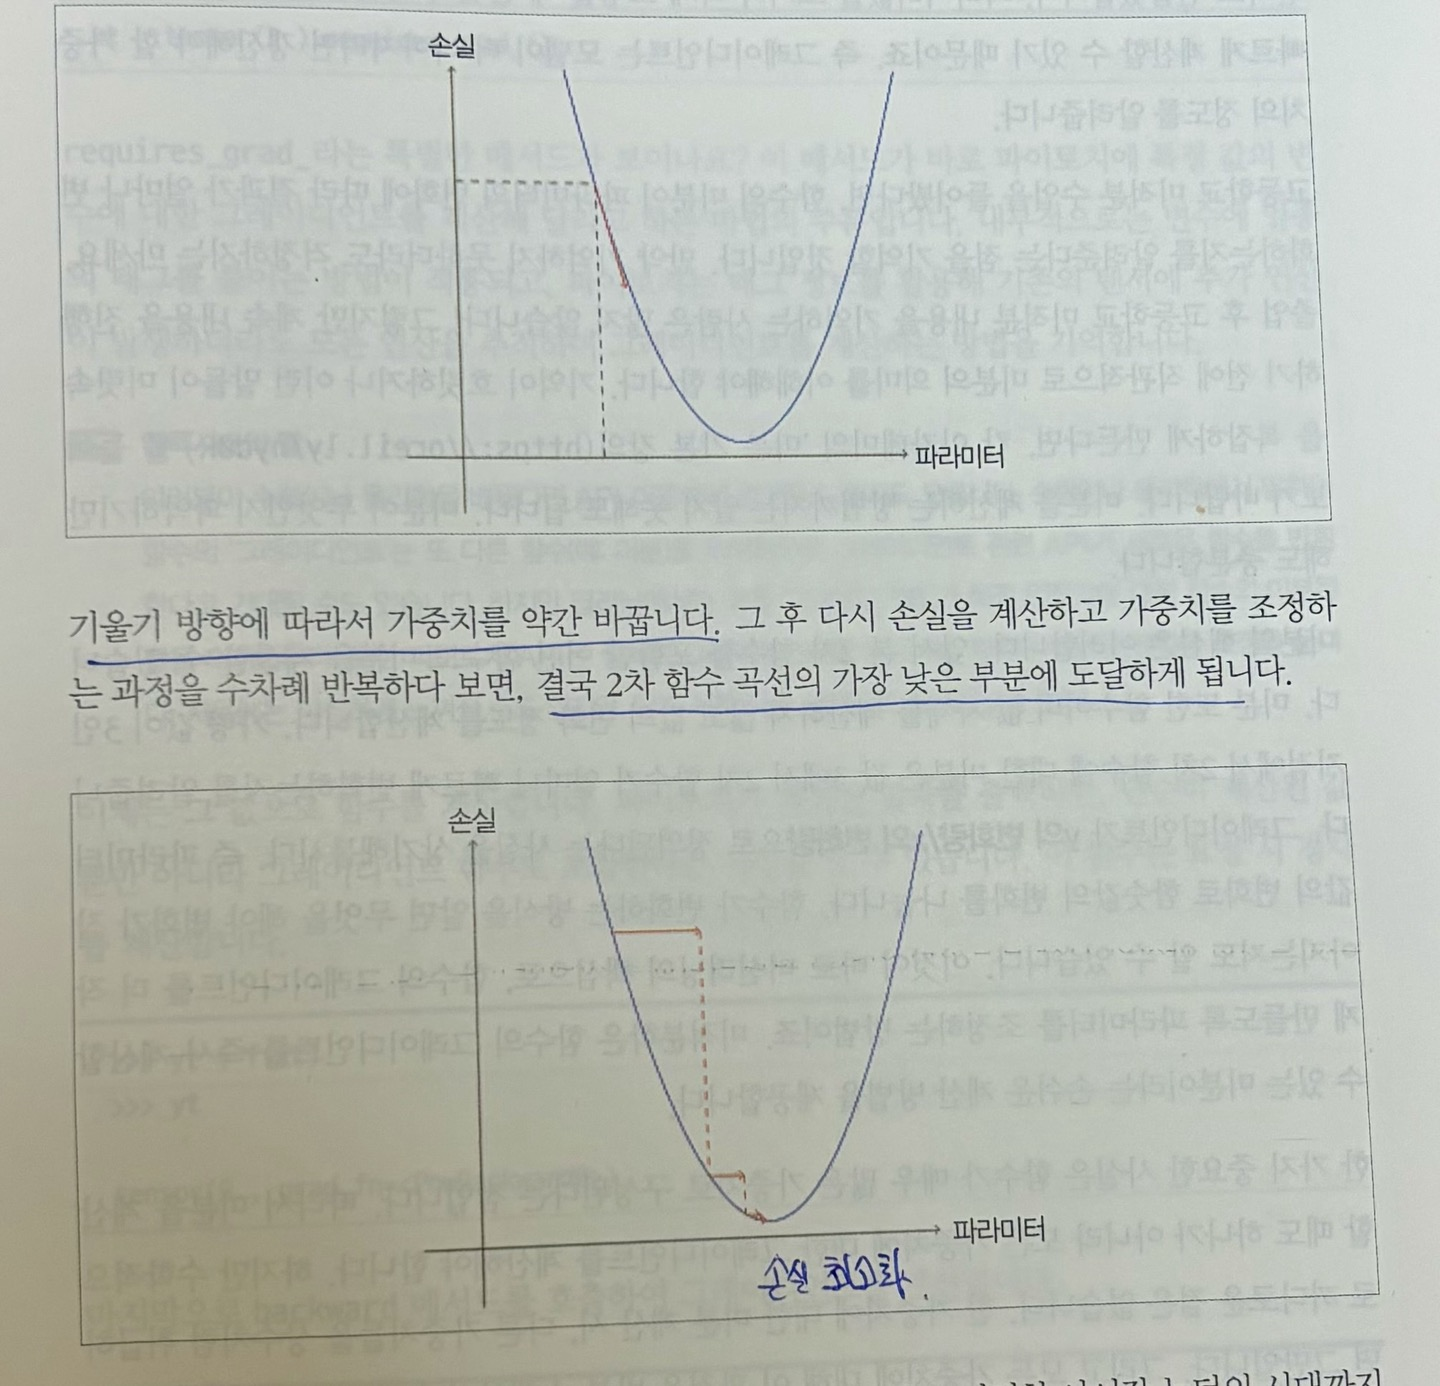

In [47]:
# 그레이디언트 계산
# - 미적분을 통해 성능 최적화함
# - 그레이디언트는 모델이 더 나아지려면 갱신해야 할 가중치의 정도를 알려줌

# 미분 정리
# - 함수의 미분이 파라미터의 변화에 따라 결과가 얼마나 변화하는지를 알려줌
# - 미분 또한 함수이며 값 자체를 계산하지 않고 값의 변화 정도를 계산함
# - 가령 값이 3인 지점에서 2차 함수에 대한 미분은 값 3에서 2차 함수가 얼마나 빠르게 변화하는지를 알려줌. 그레이디언트가 'y의 변화량/x의 변화량'으로 정의됨

# 파이토치에는 거의 모든 함수에 대한 미분을 자동으로 계산해낼 수 있음

In [48]:
xt = tensor(3.).requires_grad_() # 이 메서드가 파이토치에 특정 값의 변수에 대한 그레이디언트를 계산해 달라고 하는 기능임
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [49]:
# backward 메서드를 호출하여 그레이디언트를 계산함
yt.backward()

In [50]:
# 그레이디언트를 계산한 후 텐서의 grad 속성으로 실제 계산된 그레이디언트를 알 수 있음
xt.grad

tensor(6.)

In [51]:
# 함수에 벡터를 입력해서 그레이디언트를 구해보기
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [52]:
def f(x) :
  return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [53]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

- 그레이디언트는 함수의 기울기만 알려줌. 파라미터를 얼마나 조정해야 하는지는 알려주지 않음

- 하지만 중요한 아이디어를 제공해줌. 가령 경사가 매우 가파르면 조정을 더 많이 해야 하고, 경사가 덜 가파르면 최적의 갑에 가깝다는 사실을 알 수 있음


In [54]:
# SGD를 활용한 시작부터 끝까지를 보여주는 예제
time = torch.arange(0, 20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

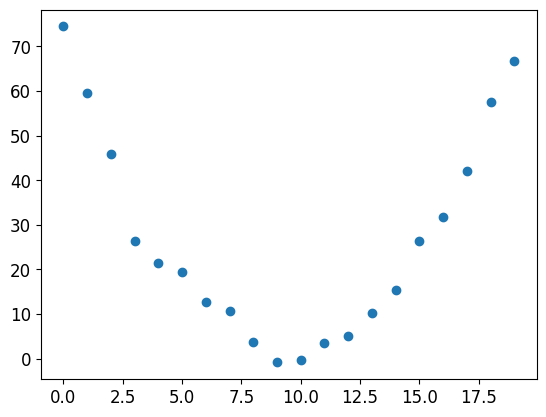

In [55]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2+1
plt.scatter(time, speed)

In [58]:
# 데이터에 가장 잘 들어맞는 2차 함수라는 제한된 함수를 찾는 문제를 다룸
def f(t, params) :
  a, b, c = params
  return a*(t**2) + (b*t) + c

# 손실 함수
# 손실 함수는 예측과 타깃을 기반으로 계산된 값을 반환하는데, 값이 낮을수록 '더 나은' 예측 결과를 얻었다는 의미임
# 분류 문제가 아닌, 연속적인 값을 예측하는 회귀 문제에서는 '평균제곱오차'라는 손실 함수를 사용함
def mse(preds, targets) :
  return ((preds - targets) ** 2).mean().sqrt()

# 밑에서는 이제 7 단계를 하나씩 다뤄봄
# - 1. 파라미터 초기화
# - 2. 예측 계산
# - 3. 손실 계산
# - 4. 그레디언트 계산
# - 5. 가중치를 한 단계 갱신
# - 6. 과정 반복
# - 7. 학습 종료

47.52345657348633
45.59833908081055
43.75083541870117
41.98754119873047
40.315040588378906
38.73967742919922
37.26729202270508
35.902854919433594
34.650150299072266
33.51140594482422


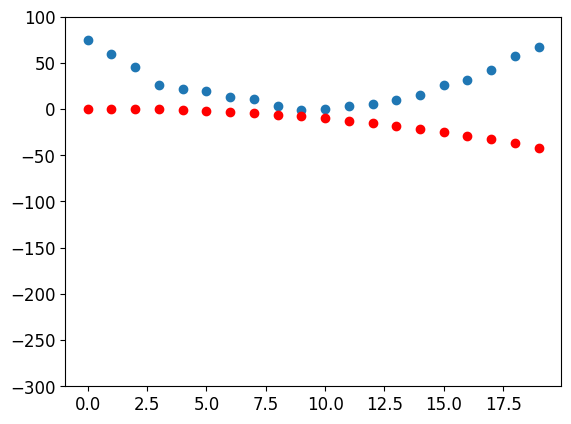

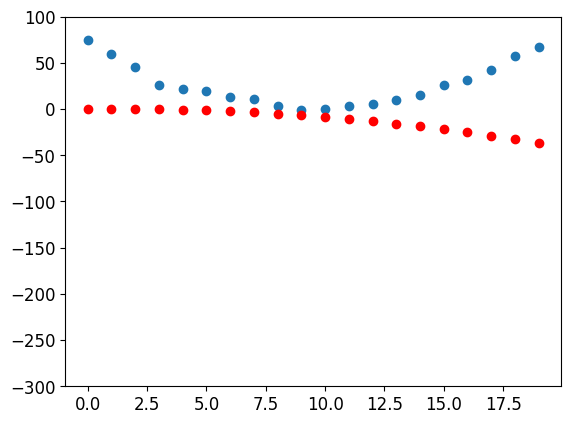

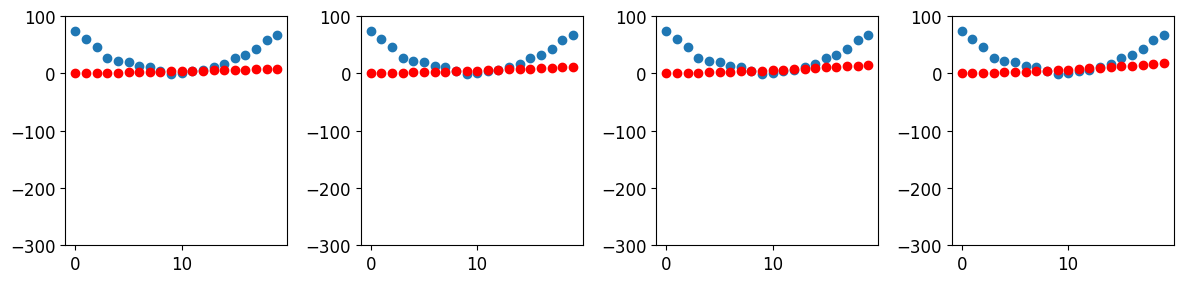

In [76]:
# - 1. 파라미터 초기화
params = torch.randn(3).requires_grad_() # 파이토치가 파라미터의 그레이디언트를 추적할 수 있도록 도와줌

# - 2. 예측 계산
preds = f(time, params) # 함수에 입력과 파라미터를 넣어서 예측을 계산함

def show_preds(preds, ax=None) :
  if ax is None :
    ax = plt.subplots()[1]

  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

show_preds(preds)

# - 3. 손실 계산
loss = mse(preds, speed)
loss

# - 4. 그레디언트 계산
loss.backward()
params.grad

params.grad * 1e-4

# - 5. 가중치를 한 단계 갱신
lr = 1e-4
params.data -= lr * params.grad.data # 계산된 그레이디언트에 기반하여 파라미터값을 갱신함
params.grad = None

# 손실이 개선되었는지 확인
preds = f(time, params)
mse(preds, speed)
show_preds(preds)

# - 6. 과정 반복
def apply_step(params, prn=True) : # 앞전에 처리한 과정을 묶은 함수
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()

  params.data -= lr * params.grad.data
  params.grad = None

  if prn :
    print(loss.item())
  return preds

for i in range(10) :  # 반복 과정을 통해 성능 향상 시키기 (153.xx -> 150.xx)
  apply_step(params)

# - 7. 학습 종료
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs :
  show_preds(apply_step(params, False), ax)

plt.tight_layout()

# 📌 경사 하강법 요약

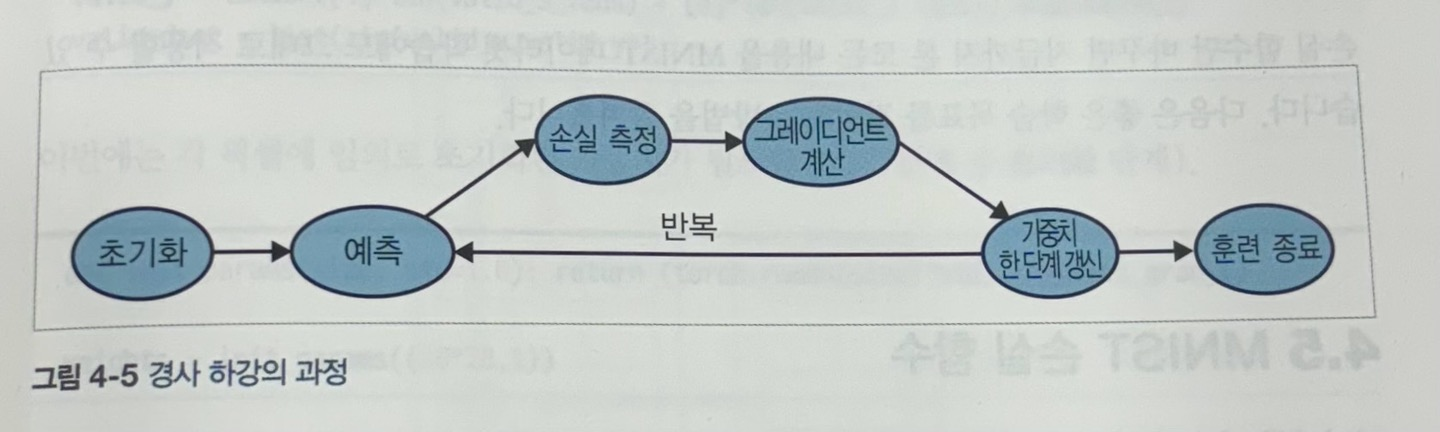


시작 단계에서는 모델의 가중치를 임의의 값으로 설정하거나(밑바닥부터 학습) 사전에 학습된 모델로부터 설정할 수 있음(전이 학습)

첫 번째 방법으로는 입력 데이터에서 원하는 결과를 얻을 수 없음. 두 번째 방법도 완벽하지 않음.

사전에 학습된 모델이 우리가 원하는 특정 문제에서 좋은 성능을 보일 가능성은 작음. 따라서, 모델은 더 나은 가중치를 학습해야함 함

손실 함수로 모델의 출력과 목표 타깃값을 비교함. 그러면 손실 함수는 가중치를 개선해서 가능한 한 낮춰야만 하는 손실값을 반환함.

이미지 같은 학습용 데이터셋의 데이터 일부를 모델에 주입함. 그리고 모델이 도출한 예측과 타깃을 손실 함수로 비교함. 그렇게 얻은 손실값은 모델의 예측이 어긋난 정도를 알려주는 단서임. 이를 기반으로 가중치를 조금 바꾸면 약간 더 나은 모델을 만들 수 있음

미적분으로 그레이디언트를 계산함. 그리고 경사진 정도(가파른 정도)에 학습률 이라는 숫자를 곱해서 한 번에 움직여야 하는 양을 알 수 있음

이 과정을 가장 낮은 등산로 입구 지점에 도달할 때까지 반복함. 그리고 도달하면 그 과정을 멈춤

# 📌 MNIST 손실 함수



In [120]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)
# 숫자 3과 7에는 각각 1과 0으로 레이블링하기
train_y = torch.tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [121]:
# 데이터 셋
dset = list(zip(train_x, train_y))

x, y = dset[0] # x열은 총 784, y는 레이블링된 값 저장
x.shape, y

(torch.Size([784]), tensor([1]))

In [122]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_x.shape, valid_y.shape
valid_dset = list(zip(valid_x, valid_y))

In [123]:
# 7 단계 중 초기화 단계
# - weights * pixels 형식의 함수는 충분히 유연치 않음
# - 직선의 방정식 y = w*x + b
# - b가 필요하므로, b 또한 임의의 숫자로 초기화함
# - w : 가중치, b : 편향, 가중치와 편향을 모두 파라미터라고 함
def init_params(size, std=1.0) :
  return (torch.randn(size) * std).requires_grad_()

weights = init_params((28*28, 1))
bias = init_params(1)

In [124]:
# 단일 이미지에 대한 예측을 계산
(train_x[0] * weights.T).sum() + bias

tensor([-33.5857], grad_fn=<AddBackward0>)

In [125]:
# 행렬 곱셈
def linear1(xb) :
  return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[-33.5857],
        [-14.1278],
        [ -6.9291],
        ...,
        [-11.1324],
        [  7.7846],
        [-11.6018]], grad_fn=<AddBackward0>)

In [126]:
# 정확도 검사
corrects = (preds>0.5).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])

In [127]:
corrects.float().mean().item()

0.4787834882736206

In [128]:
# 가중치 하나를 약간 바꿨을 때 정확도에 일어나는 변화를 실험해보기

with torch.no_grad(): weights[0] *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.47708937525749207

In [129]:
# 함수의 그레이디언트란?
# - '기울기' 또는 가파른 정도로, y가 변한 정도를 x가 변한 정도로 나눈 값
# - 즉, 입력값에 따라 함수의 출력이 위아래로 얼마나 움직였는지를 측정함
# - 밑에와 같이 작성할 수 있음
# (y_new - y_old) / (x_new - x_old)

In [130]:
trgts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])

# predictions와 targets 사이의 거리를 측정하는 손실 함수
def mnist_loss(predictions, targets) :
  # 해당 함수는 [b[i] if a[i] else c[i] for i in range(len(a))] 형식의 리스트 컴프리헨션과 같은 작업을 수행함
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [131]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [132]:
mnist_loss(preds, trgts)

tensor(4.9061, grad_fn=<MeanBackward0>)

In [133]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.2333)

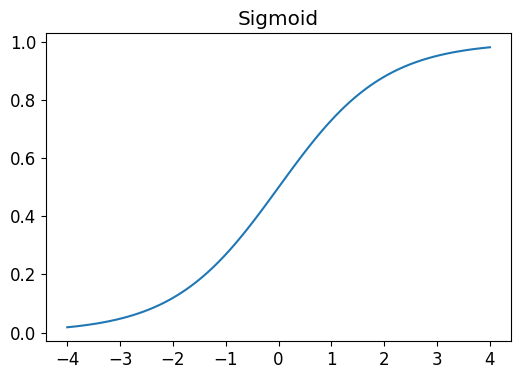

In [134]:
# 시그모이드
# - 0과 1 사이의 숫자를 출력하는 시그모이드
def sigmoid(x) :
  return 1/(1+torch.exp(-x))

# 스그모이드 함수의 생김새를 그래프로 나타내기
# - 입력값은 음수부터 양수까지 제한이 없지만, 출력값은 0과 1 사이임
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [135]:
# 먼저 입력된 값(예측값)에 시그모이드가 적용되도록 mnist_loss 함수를 갱신함
def mnist_loss(predictions, targets) :
  predictions = predictions.sigmoid()
  return torch.where(targets == 1, 1-predictions, predictions).mean()

In [136]:
# 평가지표는 사람의 이해를 돕고, 손실은 자동화된 학습을 이끌어간다는 점이 주된 차이점
# 따라서, 손실은 유의미한 미분이 있는 함수여야만 함
# 손실 함수는 데이터셋의 각 요소에 대해 계산되고, 한 에포크가 끝나는 시점에 모든 손실값의 평균을 구할 수 있음
# 평가지표는 사람이 실제로 관심을 가지는 숫자. 매 에포크의 끝에서 모델이 얼마나 학습을 잘 했는지를 알려주는 값임

In [137]:
# SGD와 미니배치

# - SGD에 적절한 손실 함수를 갖추었으므로, 그레이디언트에 기반하여 가중치를 갱신하는 학습의 다음 과정에 관련된 세부사항을 고려할 수 있음. 이를 '최적화 단계'라고 함
# - 한 번에 일정 개수의 데이터에 대한 손실의 평균을 계산함. 이를 '미니배치학습'이라고 함
# - 미니배치에 포함된 데이터 개수를 '배치 크기'라고 함
# - 배치 크기가 클수록 손실 함수로 계산되는 그레이디언트가 더 정확하고 안정적으로 추정되지만, 계산이 오래 걸림

In [138]:
# - 일반적으로는 매 에포크에 순차적으로 데이터셋을 소비하는 단순한 방식 대신 미니배치가 생성되기 전에 임의로 데이터셋을 뒤섞는 방식을 사용함
# - 파이토치와 fastai는 임의로 데이터셋을 뒤섞은 다음 미니배치를 만드는 DataLoader 클래스를 제공함
# - DataLoader는 파이썬이 제공하는 모든 컬렉션을 주어진 배치 크기 단위로 분할된 여러 배치에 접근하는 반복자로 만들어 줌
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([14,  9,  7,  0, 12]),
 tensor([ 6, 11,  4,  2,  8]),
 tensor([ 5,  3,  1, 13, 10])]

In [139]:
# - 모델 학습에는 임의의 파이썬 컬렉션을 사용해선 안됨
# - 그 대신 독립변수와 종속변수(모델의 입력과 타깃)를 모두 포함한 컬렉션이 필요함
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [140]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([20,  8,  2,  5, 12, 17]), ('u', 'i', 'c', 'f', 'm', 'r')),
 (tensor([19, 14, 15, 16, 11,  1]), ('t', 'o', 'p', 'q', 'l', 'b')),
 (tensor([23, 25,  0, 22,  6,  4]), ('x', 'z', 'a', 'w', 'g', 'e')),
 (tensor([ 3, 21, 24, 18,  9,  7]), ('d', 'v', 'y', 's', 'j', 'h')),
 (tensor([10, 13]), ('k', 'n'))]

In [141]:
# 파라미터 초기화
weights = init_params((28*28, 1))
bias = init_params(1)

# Dataset에서 DataLoader 생성
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape


(torch.Size([256, 784]), torch.Size([256, 1]))

In [142]:
# 검증용 데이터셋에도 같은 작업 적용
valid_dl = DataLoader(valid_dset, batch_size=256)
batch = train_x[:4]
batch.shape

preds = linear1(batch)
preds

tensor([[-3.8631],
        [-3.5930],
        [-3.6784],
        [-4.0069]], grad_fn=<AddBackward0>)

In [143]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9775, grad_fn=<MeanBackward0>)

In [144]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0033), tensor([-0.0219]))

In [145]:
# 모든 내용을 함수 하나로 정의

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [146]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad


(tensor(-0.0066), tensor([-0.0439]))

In [147]:
# 같은 코드를 두 번 호출
# - 그레이디언트가 변함
# - loss.backward는 지금 계산된 손실의 그레이디언트를 앞서 계산된 그레이디언트에 더하기 때문임
# - 따라서, 이전의 그레이디언트를 0으로 설정해야함
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0098), tensor([-0.0658]))

In [148]:
weights.grad.zero_()
bias.grad.zero_();

In [151]:
# 한 에포크에서 수행되는 간단한 학습 루프
def train_epoch(model, lr, params) :
  for xb, yb in dl :
    calc_grad(xb, yb, model)

    for p in params :
      p.data -= p.grad * lr
      p.grad.zero_()

(preds>0.5).float() == train_y[:4] # 각 데이터에 대한 정확도를 계산할 수 있음

tensor([[False],
        [False],
        [False],
        [False]])

In [153]:
# 위 방식으로 배치 단위의 평균 정확도를 계산하는 함수 정의
def batch_accuracy(xb, yb) :
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [155]:
# 검증용 데이터셋의 모든 배치에 batch_accuracy 함수를 적용해서 얻은 결과들의 평균을 구함
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.2535

In [156]:
# 한 에포크 동안 모델을 학습시킨 다음 정확도가 개선되는지 확인해보기
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4922

In [157]:
# 에포크를 여러 번 더 반복해보기
for i in range(20) :
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 

In [159]:
# SGD 단계를 포장하여 객체로서 다룰 수 있게끔 만들기
# 파이토치에서 해당 객체를 옵티마이저라고함

# 옵티마이저 만들기
linear_model = nn.Linear(28*28, 1) # 단일 클래스 내에 가중치와 편향 모두가 저장

w, b = linear_model.parameters()
w.shape, b.shape

# 위 파라미터 정보는 옵티마이저를 정의하는 데 활용
class BasicOptim :
  def __init__(self, params, lr) :
    self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs) :
    for p in self.params :
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs) :
    for p in self.params :
      p.grad = None

opt = BasicOptim(linear_model.parameters(), lr)


In [160]:
# 학습 루프를 밑에 처럼 간소화하기
def train_epoch(model) :
  for xb, yb in dl :
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

validate_epoch(linear_model)

0.7085

In [161]:
def train_model(model, epochs) :
  for i in range(epochs) :
    train_epoch(model)
    print(validate_epoch(model), end=' ')

train_model(linear_model, 20)

0.4932 0.7793 0.8618 0.9184 0.9355 0.9502 0.9575 0.9629 0.9658 0.9682 0.9697 0.9721 0.9736 0.9746 0.9761 0.977 0.9775 0.978 0.978 0.9785 

In [162]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7808 0.8623 0.9179 0.936 0.9502 0.957 0.9648 0.9663 0.9682 0.9702 0.9717 0.9741 0.9746 0.9761 0.9765 0.9775 0.9775 0.978 0.9785 

In [163]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636812,0.503675,0.495584,00:00
1,0.621135,0.122645,0.913641,00:00
2,0.224425,0.218196,0.793916,00:00
3,0.096488,0.115487,0.903827,00:00
4,0.049296,0.081870,0.929833,00:00
5,0.030959,0.064732,0.945535,00:00
6,0.023457,0.054246,0.954858,00:00
7,0.020178,0.047355,0.961727,00:00
8,0.018568,0.042569,0.964671,00:00
9,0.017636,0.039076,0.966634,00:00


In [164]:
#다음은 위의 클래스를 활용해서 현재의 선형 모델을 신경망 모델로 바꿔보기
def simple_net(xb) :
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res

w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)


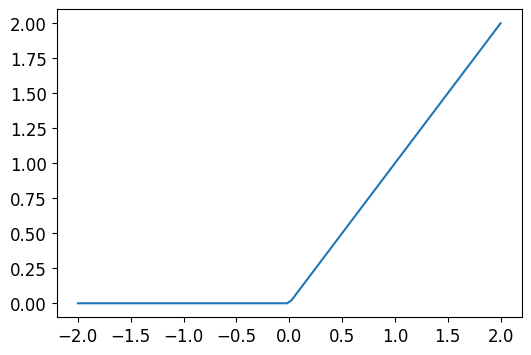

In [166]:
plot_function(F.relu)

In [167]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)



In [168]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.284475,0.404023,0.505397,00:00
1,0.136192,0.217892,0.815996,00:00
2,0.077099,0.111825,0.917566,00:00
3,0.051721,0.076292,0.942100,00:00
4,0.039808,0.059849,0.957311,00:00
5,0.033627,0.050536,0.963690,00:00
6,0.030013,0.044637,0.966143,00:00
7,0.027631,0.040583,0.967615,00:00
8,0.025896,0.037623,0.969578,00:00
9,0.024544,0.035357,0.971541,00:00


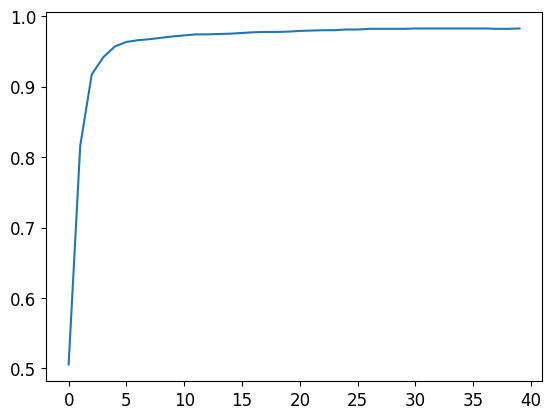

In [169]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [170]:
learn.recorder.values[-1][2]

0.982826292514801

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                     loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time


# 전문용어 정리

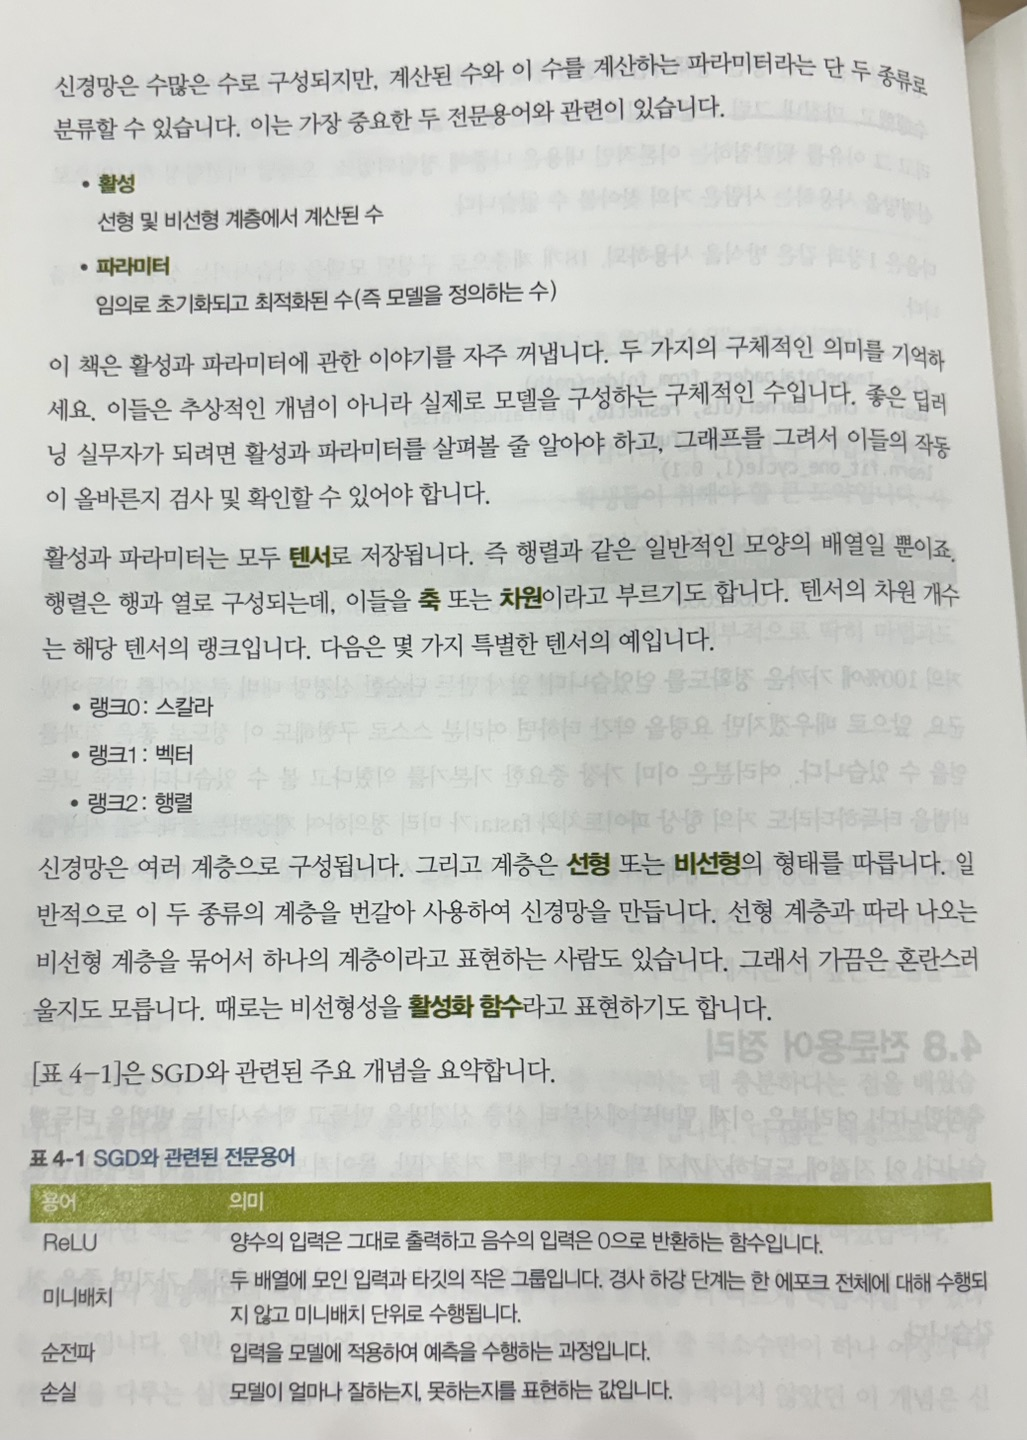

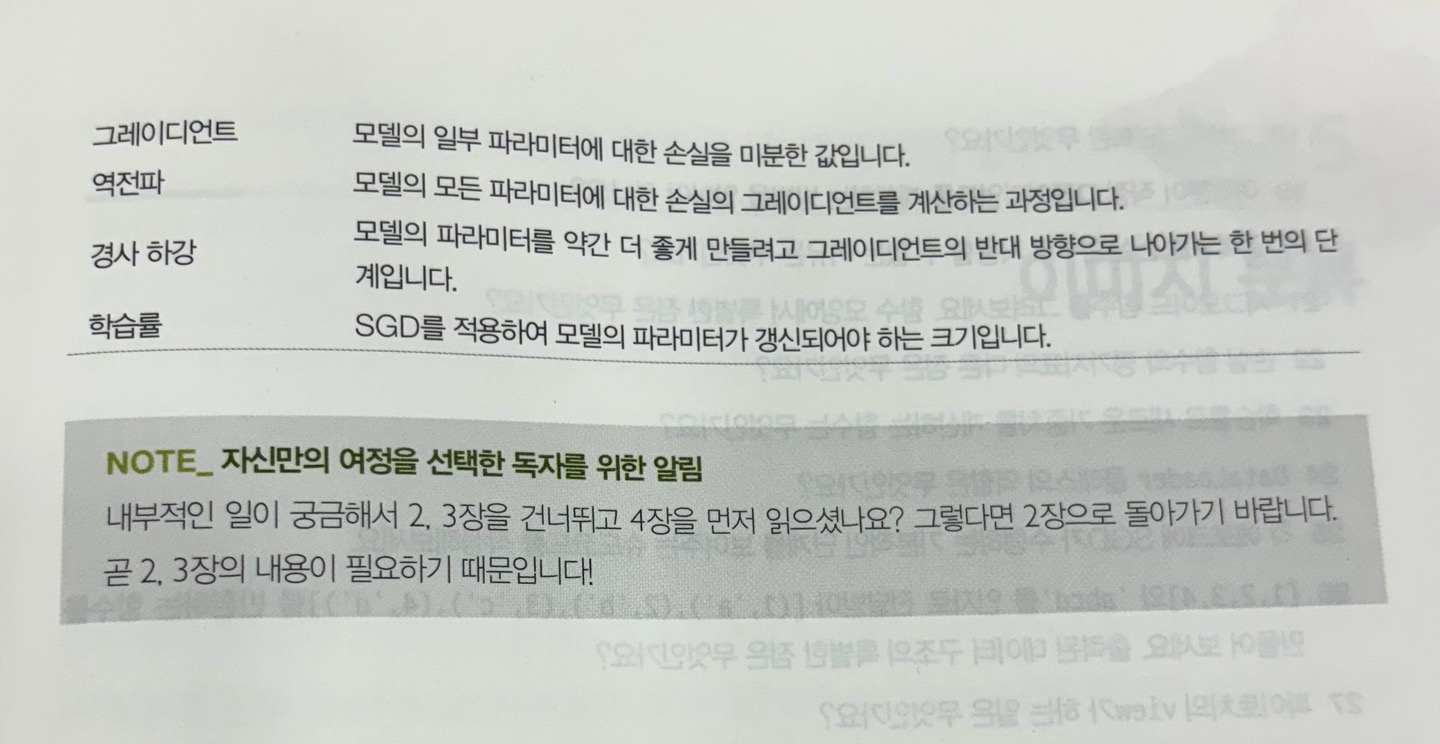